In [1]:
import scanpy as sc
import muon as mu
import numpy as np
import pandas as pd
import mofax as mofa
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
import torch
import torch.nn.functional as F
import random
import seaborn as sns
import muon as mu
import anndata
import pyromofa

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

def to_device(t): return torch.tensor(t).to(device)

/scratch/venvs/deeplife2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dir="/scratch/deeplife/"
dir="data/"
neurips = anndata.read_h5ad(dir+"neurips2021.h5ad")
# neurips.var_names_make_unique()
# neurips.layers["counts"] = neurips.X.copy()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'data/neurips2021.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [3]:
protein = pbmc[:, pbmc.var["feature_types"] == "Antibody Capture"].copy()
rna = pbmc[:, pbmc.var["feature_types"] == "Gene Expression"].copy()
rna = rna[:, rna.X.sum(axis=0) > 10].copy()

In [4]:
mofa = pyromofa.MOFA({
    'rna': torch.tensor(rna.X.toarray(), device=device),
    'protein': torch.tensor(protein.X.toarray(), device=device),
}, K=5, batch_size=128)
loss, map_estimates, trained_guide = mofa.train(num_iterations=7000)
mofa_matrices = mofa.get_matrices()

/scratch/venvs/deeplife2/lib/python3.12/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'latent factors'}
  warnings.warn(


[iteration 0001] loss: 1740383.7117


/scratch/venvs/deeplife2/lib/python3.12/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'latent factors'}
  warnings.warn(


[iteration 0201] loss: 1274026.7282
[iteration 0401] loss: 583082.6444
[iteration 0601] loss: 458537.2568
[iteration 0801] loss: 325373.0019
[iteration 1001] loss: 369787.3289
[iteration 1201] loss: 212459.7063
[iteration 1401] loss: 136490.9041
[iteration 1601] loss: 131244.7268
[iteration 1801] loss: 566672.9430
[iteration 2001] loss: 88724.1652
[iteration 2201] loss: 72532.7812
[iteration 2401] loss: 90610.3678
[iteration 2601] loss: 64101.8553
[iteration 2801] loss: 57459.0801
[iteration 3001] loss: 40981.8687
[iteration 3201] loss: 33817.6566
[iteration 3401] loss: 37386.8921
[iteration 3601] loss: 34140.4763
[iteration 3801] loss: 35750.5994
[iteration 4001] loss: 22660.1568
[iteration 4201] loss: 20125.8885
[iteration 4401] loss: 16774.0252
[iteration 4601] loss: 15420.5276
[iteration 4801] loss: 18059.0316
[iteration 5001] loss: 13586.0412
[iteration 5201] loss: 13244.5817
[iteration 5401] loss: 14772.2915
[iteration 5601] loss: 10474.1098
[iteration 5801] loss: 10472.2014
[ite

In [6]:
mofa.save_h5(pbmc.obs.index, { "rna": rna, "protein": protein }, "models/pyro-MOFA.h5", compression=1)

In [7]:
import mofax
mofax_model = mofax.mofa_model('models/pyro-MOFA.h5')

(5, 5527) (5, 32)


/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1093: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2 = r2.append(tmp)
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: Futu

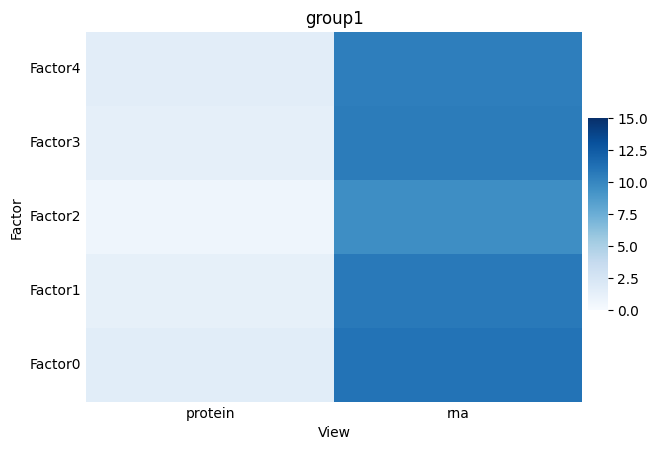

In [9]:
mofax_model
print(mofax_model.factors['group1'].shape, mofax_model.weights['protein'].shape)
mofax.plot_r2(mofax_model, x='View', vmax=15)

In [10]:
mofax_model.get_r2()

/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1093: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2 = r2.append(tmp)
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2_df = r2_df.append(
/scratch/venvs/deeplife2/lib/python3.12/site-packages/mofax/core.py:1003: Futu

,View,Group,R2,Factor
0,protein,group1,1.676828,Factor0
1,rna,group1,11.121571,Factor0
0,protein,group1,1.326144,Factor1
1,rna,group1,10.786819,Factor1
0,protein,group1,0.676972,Factor2
1,rna,group1,9.599674,Factor2
0,protein,group1,1.381230,Factor3
1,rna,group1,10.657531,Factor3
0,protein,group1,1.611120,Factor4
1,rna,group1,10.520983,Factor4


In [13]:
protein_regen = mofa_matrices.Z @ mofa_matrices.Ws["protein"].T

In [14]:
protein_regen

tensor([[48.7864, 50.1672, 34.5717,  ...,  3.5688,  3.5712,  4.3290],
        [47.4409, 48.8288, 33.5734,  ...,  3.3584,  3.4070,  4.0482],
        [43.4831, 44.8272, 30.7245,  ...,  2.8329,  2.9679,  3.3625],
        ...,
        [38.8808, 39.9130, 27.7137,  ...,  2.6211,  2.5719,  3.2265],
        [48.1160, 49.6041, 33.9555,  ...,  3.3274,  3.4781,  3.9350],
        [20.4948, 21.0338, 14.5923,  ...,  1.4712,  1.4299,  1.8209]])

In [15]:
protein.X.toarray()

array([[ 12., 280.,   9., ...,   5.,   2.,   4.],
       [ 24., 231.,  11., ...,   0.,   1.,   1.],
       [ 23., 117.,   3., ...,   1.,   4.,   2.],
       ...,
       [279.,   6., 331., ...,   1.,   2.,   3.],
       [ 11., 133.,  10., ...,   5.,   2.,   5.],
       [441., 658.,   4., ...,   2.,   3.,   2.]], dtype=float32)